# Load data from STAEformer

In [1]:
# GET PARAMETERS
import os 
import sys
import torch 
import importlib
import numpy as np 
import pandas as pd
current_file_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_file_path,'..'))
if parent_dir not in sys.path:
    sys.path.insert(0,parent_dir)

from examples.benchmark import local_get_args
from K_fold_validation.K_fold_validation import KFoldSplitter

target_data =  'PeMS08_flow'
contextual_names = ['PeMS08_occupancy','PeMS08_speed','calendar']
model_name = 'STAEformer'

config_file = importlib.import_module(f"constants.config_by_datasets.{target_data}.{model_name}")
importlib.reload(config_file)
modification = config_file.config
SEED = config_file.SEED

args_copy = local_get_args(model_name,
                            args_init=None,
                            dataset_names=contextual_names,
                            dataset_for_coverage=[target_data],
                            modification = modification)
folds = [args_copy.K_fold -1]
kfoldsplitter = KFoldSplitter(args_copy,folds)
target_ds,contextual_ds,args = kfoldsplitter.load_init_ds(normalize = True)  #,dic_class2rpz

U_train = target_ds.U_train
Utarget_train = target_ds.Utarget_train
PeMS08_occupancy_train = contextual_ds['PeMS08_occupancy'].U_train
PeMS08_speed_train = contextual_ds['PeMS08_speed'].U_train
x_train_perso = np.stack([U_train,PeMS08_occupancy_train,PeMS08_speed_train],axis=-1)
x_train_perso = x_train_perso.transpose(0,2,1,3)
y_train_perso = Utarget_train.permute(0,2,1).unsqueeze(-1).numpy()

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training and Hyper-parameter tuning with Ray is not possible
Coverage Period: 17856 elts between 2016-07-01 00:00:00 and 2016-08-31 23:55:00
Invalid dates within this fold: 0

>>>Tackle Target dataset: PeMS08_flow
   Load data from: /home/rrochas/../../data/rrochas/prediction_validation/PEMS08
   Data loaded with shape: (17856, 170)
   Init Dataset: 'torch.Size([17856, 170]). 0 Nan values
   TRAIN contextual_ds: torch.Size([10699, 170, 12])
   VALID contextual_ds: torch.Size([3567, 170, 12])
   TEST contextual_ds: torch.Size([3566, 170, 12])

>>>Tackle Contextual dataset:  PeMS08_speed
   Load data from: /home/rrochas/../../data/rrochas/prediction_validation/PEMS08
   Data loaded with shape: (17856, 170)

>>>Tackle Contextual dataset:  PeMS08_occupancy
   Load data from: /home/rrochas/../../data/rrochas/prediction_validation/PEMS08
   Data loaded with shape: (17856, 170)
   Init Dataset: '[torch.Size([17856, 170]), torch.Size([17856, 170])]. [tensor(0), tensor(0)] Nan values
   TRAIN c

In [2]:
import os 
import numpy as np 
path = os.path.expanduser('~/staeformer/data/inputs_model')
print(os.listdir(path))
for input in ['x','y']:
    for training_mode in ['train','val','test']:
        for scaled in ['','_scaled']:
            locals()[f'{input}_{training_mode}{scaled}'] = np.load(f'{path}/{input}_{training_mode}{scaled}.npy')


['x_train.npy', 'y_train.npy', 'x_val.npy', 'y_val.npy', 'x_test.npy', 'y_test.npy', 'x_train_scaled.npy', 'y_train_scaled.npy', 'x_val_scaled.npy', 'y_val_scaled.npy', 'x_test_scaled.npy', 'y_test_scaled.npy']


# Dataset égal: 

In [13]:
target_ds.tensor_limits_keeper.df_dates

,date
0,2016-07-01 00:00:00
1,2016-07-01 00:05:00
2,2016-07-01 00:10:00
3,2016-07-01 00:15:00
4,2016-07-01 00:20:00
...,...
17851,2016-08-31 23:35:00
17852,2016-08-31 23:40:00
17853,2016-08-31 23:45:00
17854,2016-08-31 23:50:00


<Axes: title={'center': 'dayofweek'}>

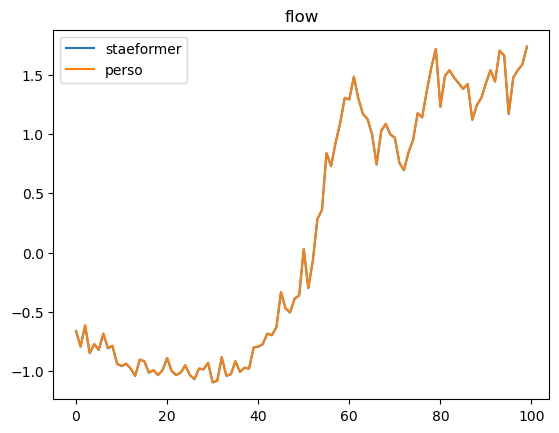

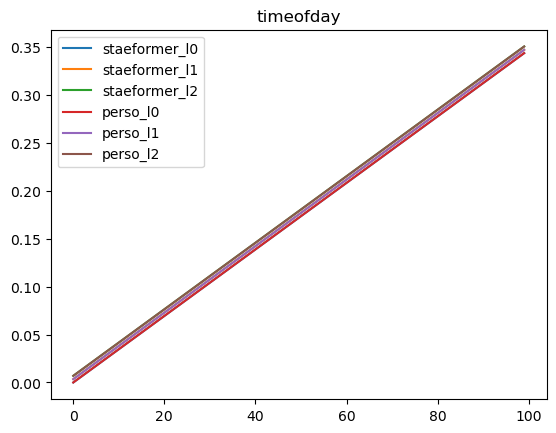

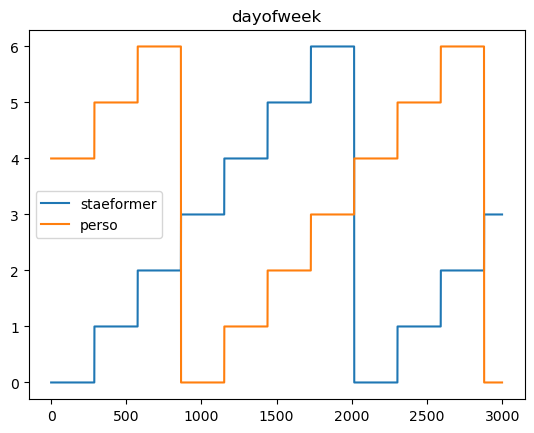

In [14]:
l = 0 
n = 0
pd.DataFrame(dict(staeformer = x_train_scaled[:-1,l,n,0], perso = x_train_perso[:,l,n,0])).iloc[:100].plot(title = 'flow')

tod = target_ds.contextual_tensors['calendar_timeofday']['train']
dow = target_ds.contextual_tensors['calendar_dayofweek']['train']
pd.DataFrame(dict(staeformer_l0 = x_train_scaled[:-1,l,n,1],
                  staeformer_l1 = x_train_scaled[:-1,l+1,n,1],
                  staeformer_l2 = x_train_scaled[:-1,l+2,n,1], 
                  perso_l0 = tod[:,l], 
                  perso_l1 = tod[:,l+1], 
                  perso_l2 = tod[:,l+2],
                  
                  )).iloc[:100].plot(title = 'timeofday')
pd.DataFrame(dict(staeformer = x_train_scaled[:-1,l,n,2], perso = dow[:,l])).iloc[:3000].plot(title = 'dayofweek')

<Axes: >

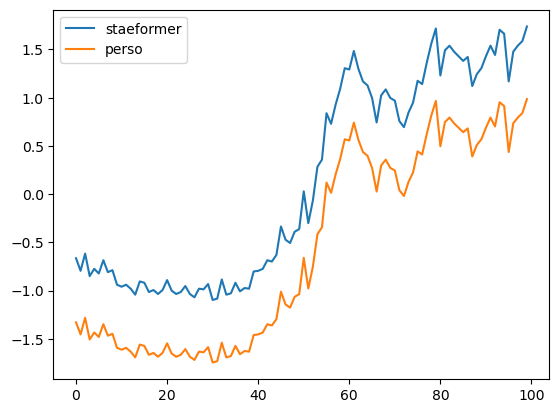

In [41]:
pd.DataFrame(dict(staeformer = x_train_scaled[:-1,0,0,0], perso = x_train_perso_scaled[:,0,0,0])).iloc[:100].plot()

<Axes: >

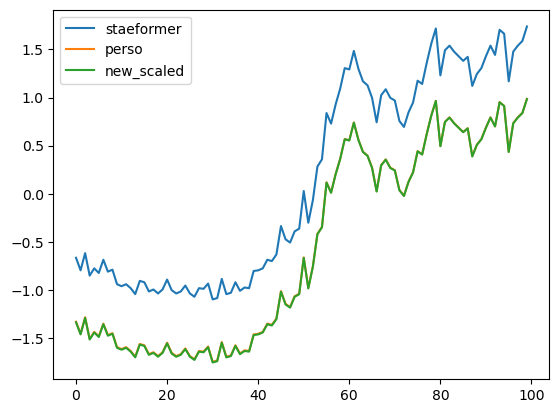

In [57]:
new_scaled = x_train_perso.copy()
std_i =  np.expand_dims(new_scaled.std(axis = 0),0)
mean_i =  np.expand_dims(new_scaled.mean(axis = 0),0)
new_scaled = (new_scaled - mean_i)/std_i


pd.DataFrame(dict(staeformer = x_train_scaled[:-1,0,0,0], 
                  perso = x_train_perso_scaled[:,0,0,0],
                  new_scaled = new_scaled[:,0,0,0]
                  )
                  ).iloc[:100].plot()

<Axes: >

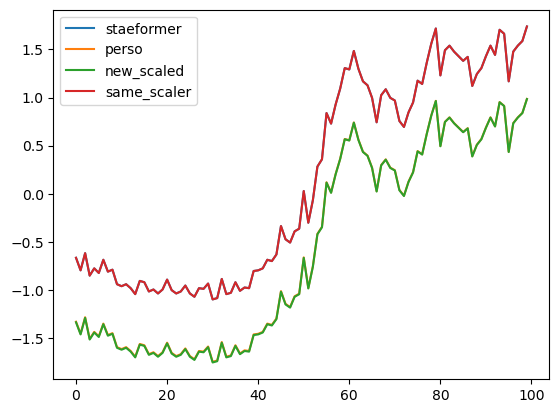

In [60]:
class StandardScaler:
    """
    Standard the input
    https://github.com/nnzhan/Graph-WaveNet/blob/master/util.py
    """

    def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std

    def fit_transform(self, data):
        self.mean = data.mean()
        self.std = data.std()

        return (data - self.mean) / self.std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean 
    

same_scaler = x_train_perso.copy()
scaler = StandardScaler(mean=same_scaler[..., 0].mean(), std=same_scaler[..., 0].std())
same_scaler[..., 0] = scaler.transform(same_scaler[..., 0])


pd.DataFrame(dict(staeformer = x_train_scaled[:-1,0,0,0], 
                  perso = x_train_perso_scaled[:,0,0,0],
                  new_scaled = new_scaled[:,0,0,0],
                  same_scaler = same_scaler[:,0,0,0]
                  )
                  ).iloc[:100].plot()